In [17]:
import os

import music21
import numpy as np
from src.utils import parse_midi_files,load_parsed_files

In [18]:
# Define the paths and constants
DATA_PATH = "data/raw/"
PARSED_DATA_PATH = "data/parsed"
PARSED_SEQUENCES_DATA_PATH = "data/parsed_sequences"
VOCAB_PATH = "data/vocab"
PARSE_MIDI_FILES = False
SEQ_LEN = 50
BATCH_SIZE = 256
EMBEDDING_DIM = 128
KEY_DIM = 256
N_HEADS = 4
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
EPOCHS = 1

In [19]:
# Get the list of midi files
file_names = [os.path.join(DATA_PATH,f) for f in os.listdir(DATA_PATH) if f.endswith(".mid")]
len(file_names)

36

In [20]:
# define the parser
parser = music21.converter

In [21]:
# Parse the midi files
if PARSE_MIDI_FILES:
    sequence_notes, sequence_durations = parse_midi_files(
        file_names, parser, SEQ_LEN + 1, PARSED_SEQUENCES_DATA_PATH
    )
else:
    sequence_notes, sequence_durations = load_parsed_files(PARSED_SEQUENCES_DATA_PATH)
len(sequence_notes),len(sequence_durations)

(27581, 27581)

In [22]:
example_notes = sequence_notes[658]
example_durations = sequence_durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 B3 C4 G3 E3 D3 C3 E3 A3 C4 F#3 A3 C4 E4 D4 C3 B2 G3 A2 G2 D2 A2 G3 F#3 G3 G2 B2 D3 G3 B3 D4 F#4 G4 D4 B3 G3 G2 A3 A3 F#3 G3 A3 D3 E3 F#3 G3 A3 F#3 D3 C3 B2 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 1.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


In [25]:
from src.vectorization import VectorizeLayer

# Create the vectorizer layer for notes
notes_vectorizer = VectorizeLayer(special_tokens=["[UNK]",""])
notes_vectorizer.adapt(sequence_notes)
notes_vectorizer.save_vocab(os.path.join(VOCAB_PATH,"notes_vocab.json"))

# Create the vectorizer layer for durations
durations_vectorizer = VectorizeLayer(special_tokens=["[UNK]",""])
durations_vectorizer.adapt(sequence_durations)
durations_vectorizer.save_vocab(os.path.join(VOCAB_PATH,"durations_vocab.json"))

len(notes_vectorizer.vocab),len(durations_vectorizer.vocab)

Vocab saved to data/vocab/notes_vocab.json
Vocab saved to data/vocab/durations_vocab.json


(59, 24)

In [8]:
# tokenize the notes and durations
notes_tokenized = notes_vectorizer(sequence_notes)
durations_tokenised = durations_vectorizer(sequence_durations)
notes_tokenized.shape,durations_tokenised.shape

(torch.Size([27581, 51]), torch.Size([27581, 51]))

In [9]:
from src.dataset import MusicDataset
from torch.utils.data import DataLoader

# Create a dataset and dataloader
dataset = MusicDataset(notes_tokenized,durations_tokenised,SEQ_LEN)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
len(dataloader)

108

In [10]:
# Get a batch of data
x_note,x_duration,y_note,y_duration = next(iter(dataloader))
x_note.shape,x_duration.shape,y_note.shape,y_duration.shape

(torch.Size([256, 50]),
 torch.Size([256, 50]),
 torch.Size([256, 50]),
 torch.Size([256, 50]))

In [11]:
from src.embedding import TokenAndPositionEmbedding

# Define the embedding layers
embed_notes_layer = TokenAndPositionEmbedding(notes_vectorizer.vocab_size,embed_dim=128)
embed_durations_layer = TokenAndPositionEmbedding(durations_vectorizer.vocab_size,embed_dim=128)


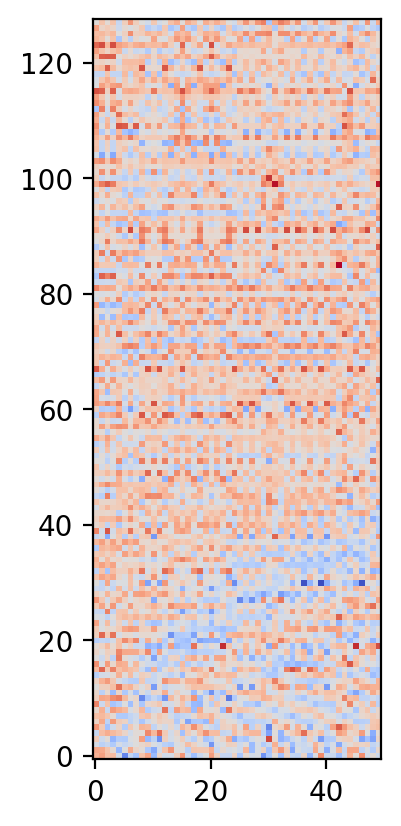

In [12]:
import matplotlib.pyplot as plt

# visualize the embedding layers
embedding_example = embed_notes_layer(x_note)

plt.imshow(
    np.transpose(embedding_example.detach().numpy()[0]),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [13]:
from src.model import MusicModel

model = MusicModel(notes_vectorizer.vocab_size,durations_vectorizer.vocab_size,EMBEDDING_DIM,N_HEADS,KEY_DIM,FEED_FORWARD_DIM,DROPOUT_RATE)

In [14]:
from torch import nn
import torch

# Create the model
x_note,x_duration,y_note,y_duration = next(iter(dataloader))
out_note,out_duration,att_score = model(x_note,x_duration)
out_note.shape,out_duration.shape,att_score.shape

(torch.Size([256, 50, 59]),
 torch.Size([256, 50, 24]),
 torch.Size([256, 50, 50]))

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [16]:

from src.trainer import MusicTrainer

trainer = MusicTrainer(model=model,
                       train_loader=dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device="cpu",
                       note_vocab_size=notes_vectorizer.vocab_size,
                       duration_vocab_size=durations_vectorizer.vocab_size,
                       save_freq=1,
                       checkpoint_dir="checkpoints",
                       remove_previous_models=True)

trainer.train(10)


Checkpoint loaded from  checkpoint_1.pt


Epoch 9: 100%|██████████| 108/108 [00:14<00:00,  7.23it/s, duration=0.52, note=2.29, total=2.81] 
